<table>
<tr>
<td width=15%><img src="./téléchargement.png"></téléchargement></td>
<td><center><h1>UE Apprentissage Statistique II</h1><br/>Master 2 parcours SSD</center></td>
<td width=20%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Bertran VADIM</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Cheikh Darou BEYE</a></td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 14pt; font-weight: bold">Examen mi-parcours </a></center>
<td><center><br/>Automne 2022</center></td>
<br/><br/>

In [139]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from custom_transformers.standard_true_false import standard_true_false

ModuleNotFoundError: No module named 'custom_transformers'

# Introduction

Dans le cadre du module de formation Apprentissage Statistique II, nous travaillons sur une problématique de classification binaire visant à prédire si une bactérie est résistante ou suceptible à divers antibiotiques à partir de trois matrices de descripteurs:
- une matrice contenant des variables binaires codant pour la présence ou l’absence de différents gènes de résistance dans le génome de la bactérie
- une matrice contenant d’autres variables binaires codant pour la présence de mutations ponctuelles (SNPs) au sein de certains gènes.
- et une matrice contenant des variables quantitatives quantifiant l’expression de différents gènes.

L'objectif de notre étude est (i) d’évaluer quel niveau de performance peut être atteinte pour prédire la résistance aux différents antibiotiques, et (ii) quelles sources d’information sont les plus pertinentes pour chacun d’entre eux.

Pour ce faire nous disposons d'un jeu de données  qui met en jeu **414 souches bactériennes**, stocké dans un fichier "pickle"
contenant les objets suivants :
- un data-frame pandas appelé pheno contenant les phénotypes de résistance (0 = susceptible ; 1 = résistant) pour les différents antibiotiques.
- une matrice (binaire) numpy appelée X_gpa codant pour la présence / absence de 16005 gènes.
- une matrice (binaire) numpy appelée X_snps codant pour la présence / absence de 72236 SNPs.
- et une matrice (quantitative) numpy appelée X_genexp contenant les mesures d’expression de 6026 gènes.

Dans la suite de ce rapport nous utiliserons diverses méthodes afin de prédire si une bactérie est résistante ou suceptible à divers antibiotiques. Le but étant de choisir le meilleur modèle, par conséquent, nous nous baserons sur leur score, leur courbe **ROC** (**AUC**) ainsi que leur **matrice de confusion** afin de les évaluer et de déceler d’éventuelles sur-apprentissages.


# Statistique descriptive

In [140]:
# Jeu de données 
import pickle
file = open('dataset.pkl','rb')
DATA = pickle.load(file)
pheno = DATA['pheno']
X_gpa = DATA['X_gpa']
X_snps = DATA['X_snps']
X_genexp = DATA['X_genexp']

In [141]:
pheno.shape
pheno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   strain_ids     414 non-null    object 
 1   Tobramycin     406 non-null    float64
 2   Ceftazidim     334 non-null    float64
 3   Ciprofloxacin  358 non-null    float64
 4   Meropenem      354 non-null    float64
 5   Colistin       414 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 22.6+ KB


In [130]:
pheno

,strain_ids,Tobramycin,Ceftazidim,Ciprofloxacin,Meropenem,Colistin
0,CF592_Iso2,0.0,1.0,0.0,NaN,0
1,CF609_Iso3,NaN,1.0,0.0,1.0,0
2,CH2500,0.0,0.0,1.0,0.0,0
3,CH2502,0.0,NaN,NaN,1.0,0
4,CH2522,0.0,1.0,NaN,NaN,1
...,...,...,...,...,...,...
409,ZG5089456,1.0,1.0,1.0,1.0,0
410,ZG8006959,1.0,1.0,1.0,1.0,0
411,ZG8038581181,1.0,1.0,1.0,1.0,0
412,ZG8510487,1.0,1.0,1.0,1.0,0


In [131]:
#### Remplaçons les valeurs manquantes par 0.0
pheno.fillna({'Tobramycin': 0.0, 'Ceftazidim': 0.0, 'Ciprofloxacin': 0.0, 'Meropenem': 0.0, 
              'Colistin': 0.0,}, inplace=True)
pheno

,strain_ids,Tobramycin,Ceftazidim,Ciprofloxacin,Meropenem,Colistin
0,CF592_Iso2,0.0,1.0,0.0,0.0,0
1,CF609_Iso3,0.0,1.0,0.0,1.0,0
2,CH2500,0.0,0.0,1.0,0.0,0
3,CH2502,0.0,0.0,0.0,1.0,0
4,CH2522,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...
409,ZG5089456,1.0,1.0,1.0,1.0,0
410,ZG8006959,1.0,1.0,1.0,1.0,0
411,ZG8038581181,1.0,1.0,1.0,1.0,0
412,ZG8510487,1.0,1.0,1.0,1.0,0


In [132]:
X_gpa.shape

(414, 16005)

In [133]:
X_snps.shape

(414, 72236)

In [134]:
X_genexp.shape

(414, 6026)

In [135]:
X_gpa

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

<BarContainer object of 2 artists>

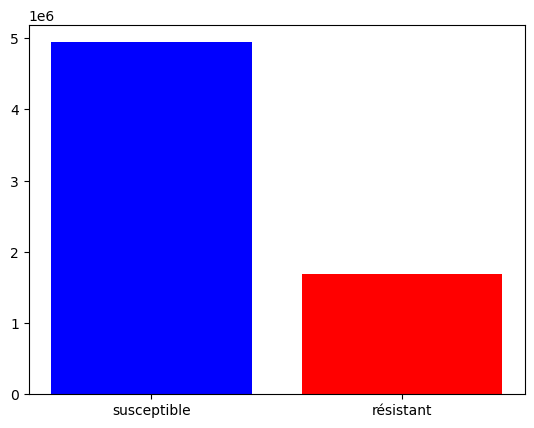

In [114]:
X_gpa = np.ravel(X_gpa).astype(int)
## Représentation des effectifs par classe
h = np.bincount(X_gpa)
plt.bar(['0','1'],h,color=['blue','red'],tick_label=['susceptible','résistant'])

<BarContainer object of 2 artists>

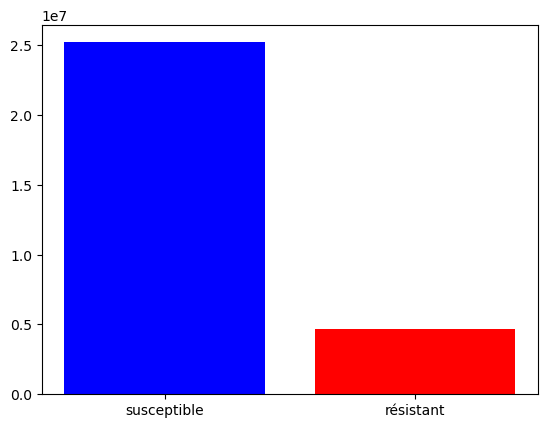

In [58]:
X_snps = np.ravel(X_snps).astype(int)
## Représentation des effectifs par classe
h = np.bincount(X_snps)
plt.bar(['0','1'],h,color=['blue','red'],tick_label=['susceptible','résistant'])

In [142]:
X_gpa_genexp = np.concatenate([X_gpa, X_genexp], axis=1)
X_snps_genexp = np.concatenate([X_snps, X_genexp], axis=1)
X_gpa_snps = np.concatenate([X_gpa, X_snps], axis=1)
X_all = np.concatenate([X_gpa, X_snps, X_genexp], axis=1)

Y = pd.DataFrame(pheno.iloc[:, 1:])
Y = Y.set_index(pheno["strain_ids"])
Y = Y.fillna(-1)

C:\Users\cheik\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


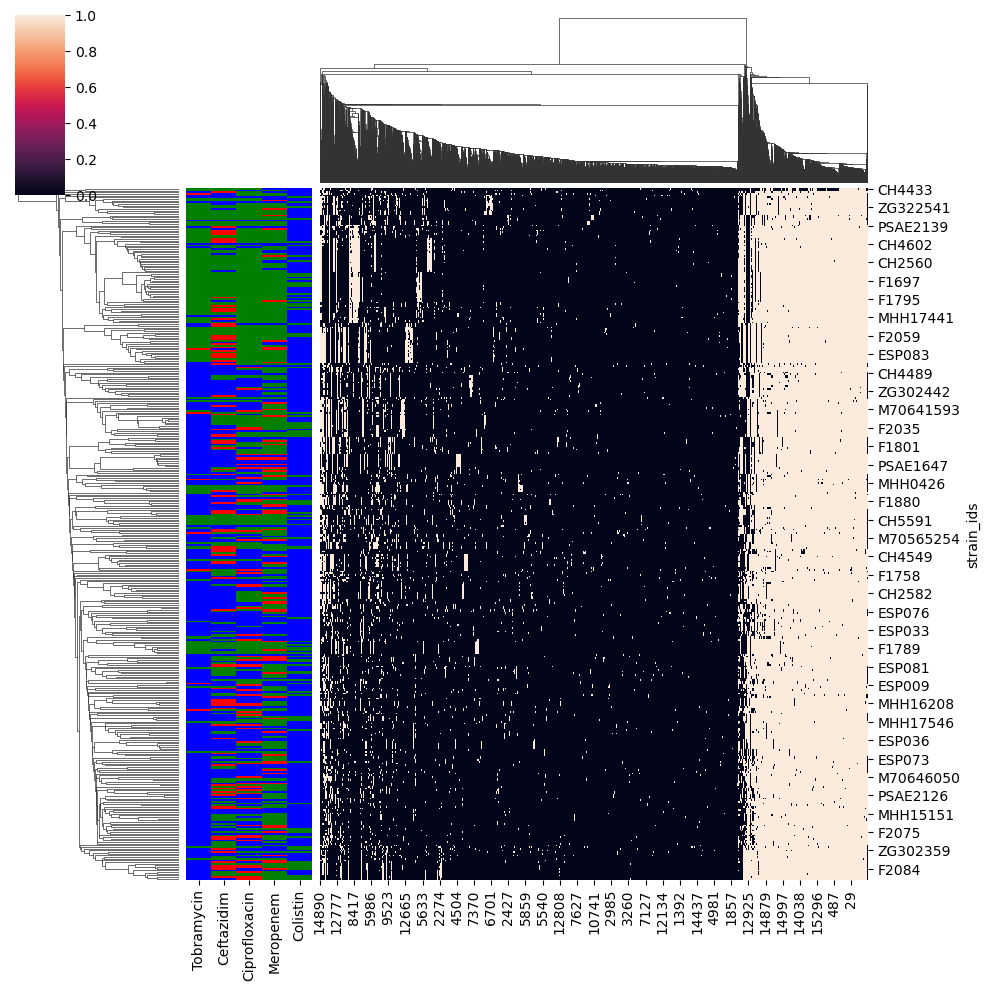

In [143]:
X = pd.DataFrame(X_gpa, index=pheno["strain_ids"])
lut = dict(zip(Y.iloc[:, 1].unique(), "gbr"))
row_colors = Y.applymap(lambda x: lut[x])
sns.clustermap(X, row_colors=row_colors)